In [1]:
from project_functions import *
sns.set(rc={'figure.figsize':(15,8)})

In [2]:
mdotm_train_feat = pd.read_csv('input_train.csv', index_col=0)
mdotm_train_tgt = pd.read_csv('label_train.csv', index_col=0).rename({'0':'target'}, axis=1)
mdotm_test_feat = pd.read_csv('input_test.csv', index_col=0)

# rename features
mdotm_train_feat.columns = [f'f{i}' for i in mdotm_train_feat.columns]
mdotm_test_feat.columns = mdotm_train_feat.columns

# df dataset contains labeled data
df = mdotm_train_tgt.join(mdotm_train_feat)

# set target labels as 0, 1
df['target'] = df['target'].mask(df['target']==-1, 0)

# Check if target is balanced (yes it is) and if there are missing values (no)
print('values count', df.target.value_counts())
print('missing values', df.isna().sum().sum())

# shuffle train set with explicit seed for reproducibility
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

values count target
1    27000
0    27000
Name: count, dtype: int64
missing values 0


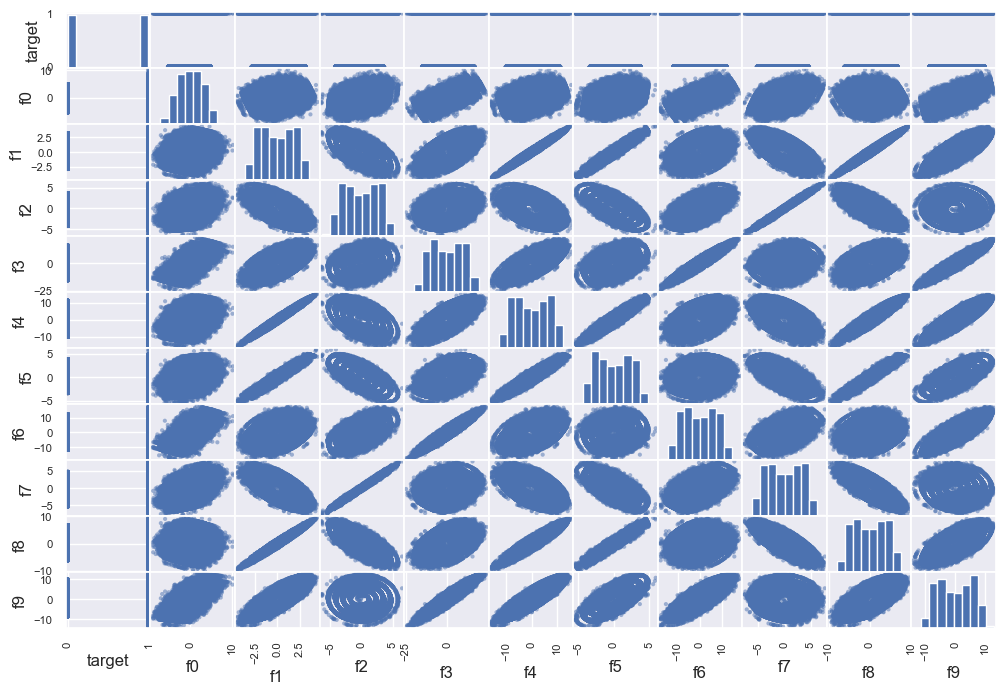

In [3]:
scatter_matrix(df, figsize=(12, 8))
plt.show()

<Axes: >

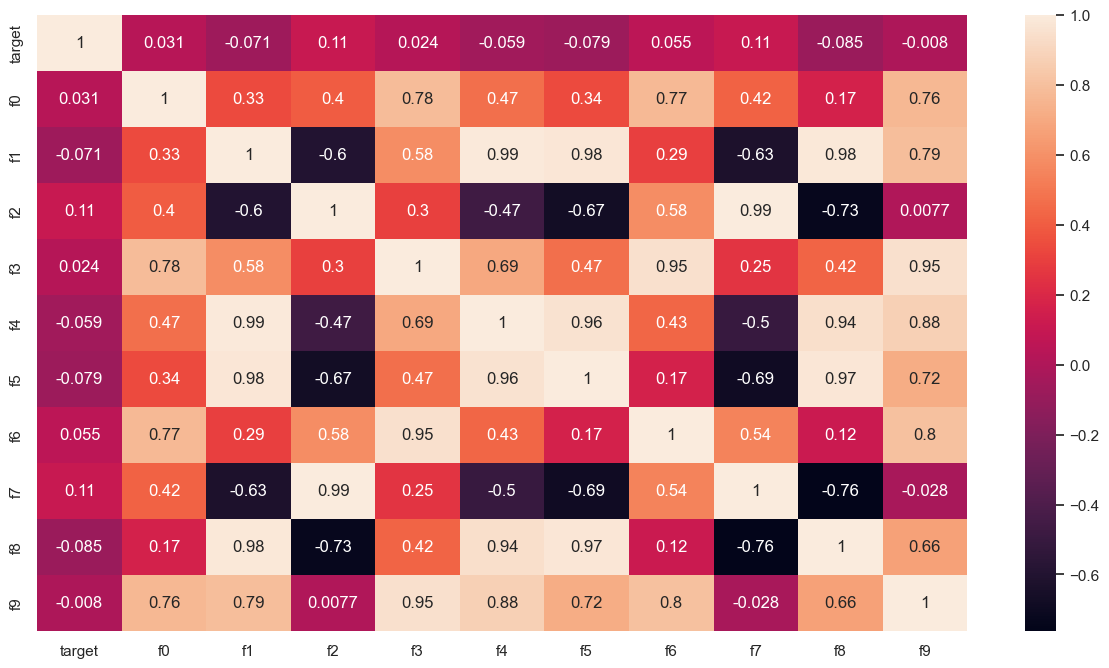

In [4]:
sns.heatmap(df.corr(method='spearman'), annot=True)

## Manifold Learning

In [5]:
features = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']

# perform train, validation, test splitting and scale data
train = df.iloc[:int(len(df)*0.6)].copy()
valid = df.iloc[int(len(df)*0.6):int(len(df)*0.8)].copy()
test = df.iloc[int(len(df)*0.8):].copy()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train[features])
X_valid_scaled = scaler.transform(valid[features])
X_test_scaled = scaler.transform(test[features])

y_train = train['target']
y_valid = valid['target']
y_test = test['target']

# Fit Kernel PCA for dimensionality reduction
rbf_pca = KernelPCA(n_components = 3, kernel = 'rbf', gamma = 0.025, random_state=1)
X_train_kpca = rbf_pca.fit_transform(X_train_scaled)
X_valid_kpca = rbf_pca.transform(X_valid_scaled)
X_test_kpca = rbf_pca.transform(X_test_scaled)
X_train_kpca = pd.DataFrame(X_train_kpca, columns = ['kpca1', 'kpca2', 'kpca3'], index=train.index)
X_valid_kpca = pd.DataFrame(X_valid_kpca, columns = ['kpca1', 'kpca2', 'kpca3'], index=valid.index)
X_test_kpca = pd.DataFrame(X_test_kpca, columns = ['kpca1', 'kpca2', 'kpca3'], index=test.index)

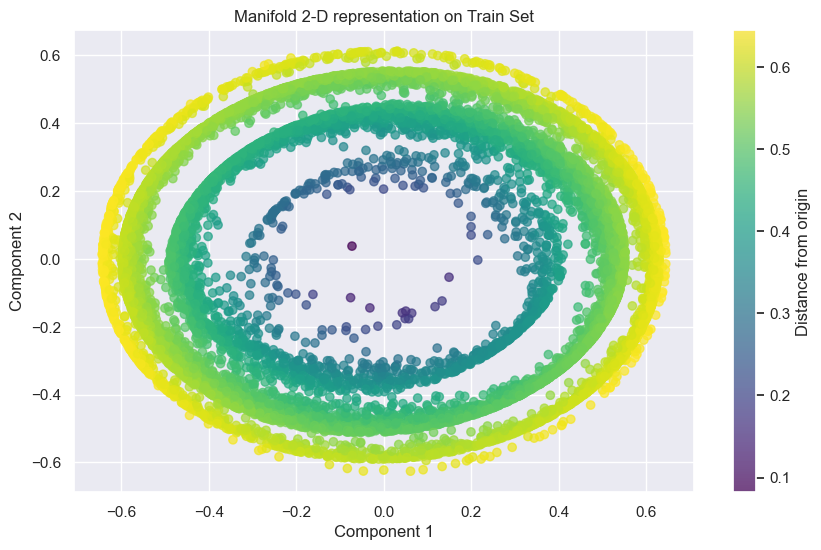

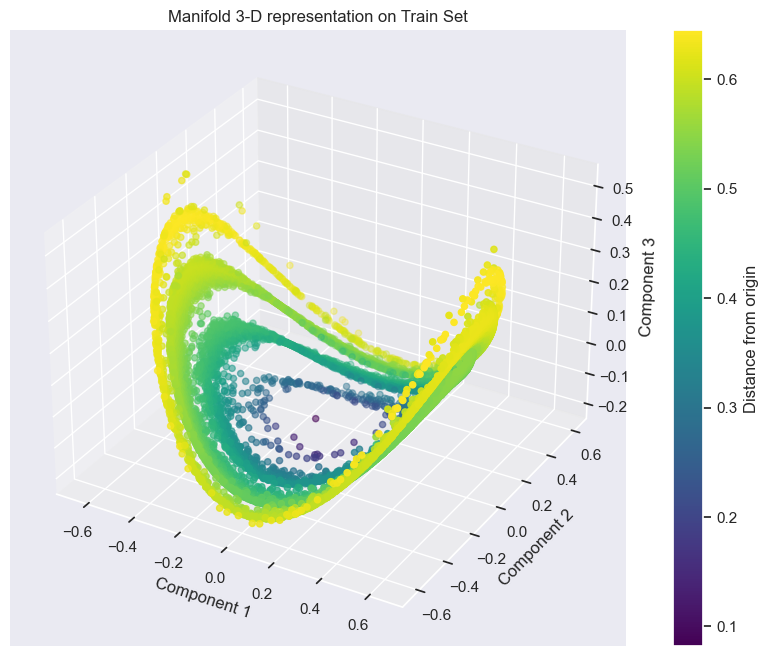

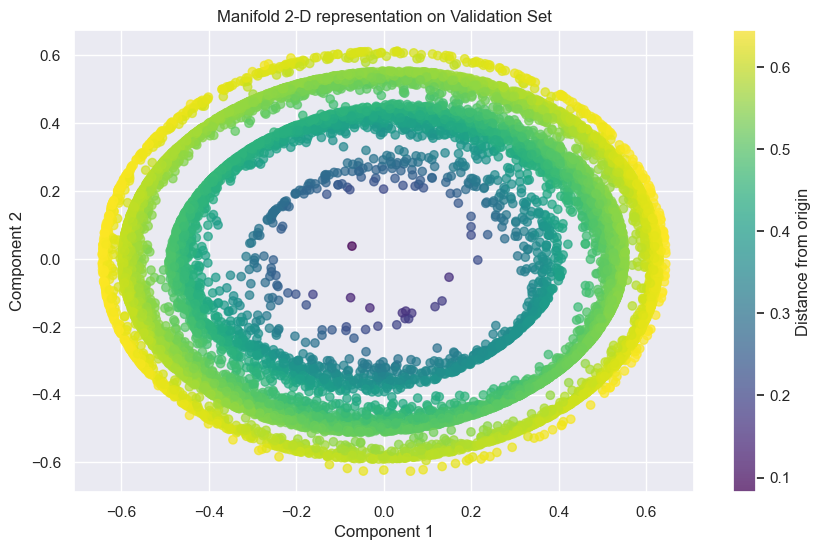

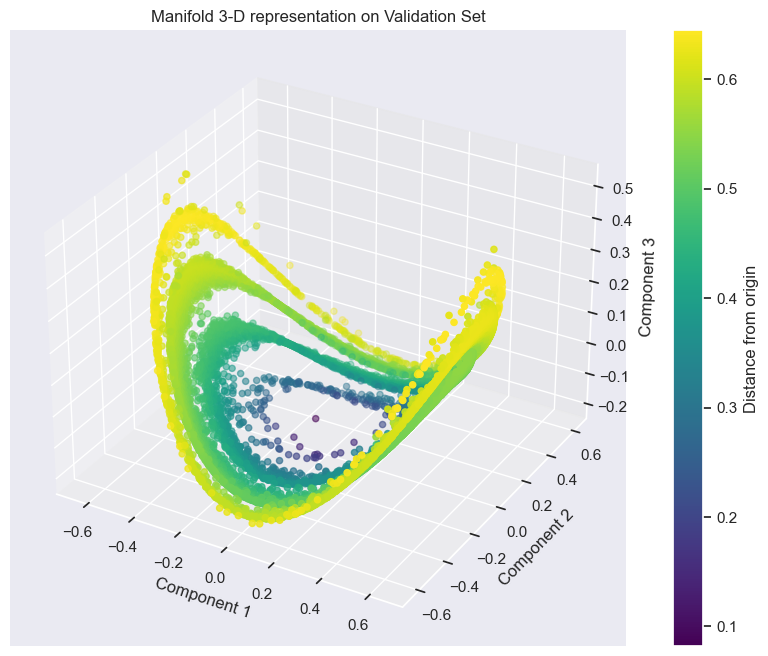

In [8]:
plot_2d(X_test_kpca['kpca1'], X_test_kpca['kpca2'], 'Manifold 2-D representation on Train Set')
plot_3d(X_test_kpca['kpca1'], X_test_kpca['kpca2'], X_test_kpca['kpca3'], 'Manifold 3-D representation on Train Set')

plot_2d(X_test_kpca['kpca1'], X_test_kpca['kpca2'], 'Manifold 2-D representation on Validation Set')
plot_3d(X_test_kpca['kpca1'], X_test_kpca['kpca2'], X_test_kpca['kpca3'], 'Manifold 3-D representation on Validation Set')

## Features engineering

In [13]:
train = train.join(X_train_kpca)
valid = valid.join(X_valid_kpca)
test = test.join(X_test_kpca)

features += list(X_train_kpca.columns)

# repeat scaling to include new features ##### necessario  ? ? ?? 
X_train_scaled = scaler.fit_transform(train[features])
X_valid_scaled = scaler.transform(valid[features])
X_test_scaled = scaler.transform(test[features])

In [14]:
train

,target,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,kpca1,kpca2,kpca3
0,1,1.400788,2.549015,0.628987,18.160596,9.788586,2.138102,12.857064,0.036288,4.626454,10.095546,0.549092,-0.254900,0.183690
1,1,2.543950,-1.574838,2.451086,-0.959649,-4.626089,-1.591448,1.246607,3.347377,-3.872772,-1.417373,-0.304504,-0.317610,-0.081342
2,1,0.988902,-0.417661,4.131473,13.025676,-0.183744,-1.590319,12.699482,4.395259,-1.877111,4.478617,-0.001757,-0.547662,-0.188493
3,1,0.059897,1.028140,0.828386,9.618243,4.019595,0.549006,7.386414,0.503744,1.782481,4.721413,0.294111,-0.214197,-0.098576
4,0,3.191505,2.737630,-0.638828,14.163181,10.445884,3.128176,8.623969,-0.993835,5.105809,9.502441,0.607461,-0.152345,0.249716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32395,0,-1.358914,-2.370574,2.853208,-3.707649,-8.139508,-3.221486,0.362643,3.371029,-5.104716,-4.694612,-0.526437,-0.203581,0.113928
32396,0,-0.476129,1.613145,-2.898363,-0.888349,5.014243,2.228751,-3.271331,-3.470030,3.841171,1.501857,0.342048,0.326812,-0.063722
32397,1,1.177225,-1.148079,2.394921,1.752646,-3.322817,-1.522705,3.277823,2.934720,-2.897192,-0.385183,-0.232230,-0.320406,-0.128874
32398,1,-4.133536,-2.281331,1.470139,-7.942555,-8.705898,-3.258808,-3.410412,1.521474,-4.325027,-7.036159,-0.567282,0.041819,0.166021


In [63]:
# n_estimators, learning rate, max_depth, gamma
grid_search_params = [
            [100, 200, 300, 500, 1000], # n_estimators
            [0.001, 0.01, 0.1, 0.5, 0.8], # learning_rate
            [3, 6, 9, 12], # max_depth
            [0, 1, 2], # gamma
        ]

model_configs = []
for elem in itertools.product(*grid_search_params):
    model_configs.append(elem)

best_accuracy = 0
best_params = None

for param_gs in tqdm.tqdm(model_configs):
    # fit model on training data
    model = XGBClassifier(n_estimators=param_gs[0],
            learning_rate=param_gs[1],
            max_depth=param_gs[2],
            gamma=param_gs[3],
            eval_metric="logloss",
        )
    
    eval_set = [(X_train_scaled, y_train), (X_valid_scaled, y_valid)]
    model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

    # make predictions for validation data
    y_pred_valid = model.predict(X_valid_scaled)

    # evaluate predictions
    accuracy = accuracy_score(y_valid, y_pred_valid)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = param_gs
        best_model = model
        best_mod_results = model.evals_result()

100%|██████████| 300/300 [06:27<00:00,  1.29s/it]


In [64]:
best_params

(200, 0.1, 9, 0)

In [65]:
best_accuracy

0.9919444444444444

In [66]:
best_mod_results.keys()

dict_keys(['validation_0', 'validation_1'])

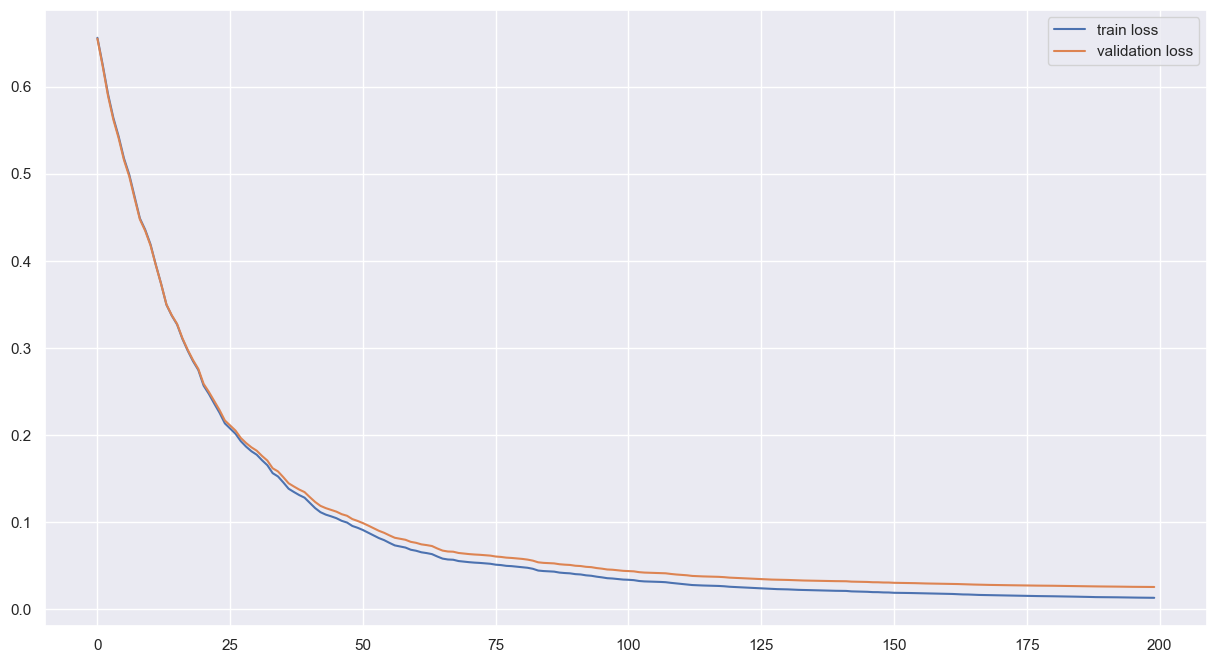

In [72]:
plt.plot(best_mod_results['validation_0']['logloss'])
plt.plot(best_mod_results['validation_1']['logloss'])
plt.legend(['train loss', 'validation loss'])
plt.show()

In [68]:
accuracy_score(y_test, best_model.predict(X_test_scaled))

0.9903703703703703